In [1]:
regenerate = False

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

plt.rcdefaults()

In [3]:
asymptote_sample_size = 10
snap_index = 0

In [4]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [5]:
# Would it be more helpful to create a logspace?
onh2s = np.linspace(0, 0.01, 100)
onh2_strs = [str(np.around(onh2e, 4)) for onh2e in onh2s]

In [6]:
spec_sims = None

if regenerate:
    # It's a waste of time to consider all of the omegas and snapshots, so we're
    # making heavy use of skips.
    spec_sims = spectra.better_battery(onh2s, onh2_strs,
        skips_omega=[], skips_model=[8], skips_snapshot=[1, 2, 3], h_units=False)
    np.save("spec_sims.npy", spec_sims, allow_pickle=True)
else:
    # .item() is a little strange, but it allows me to recover a Python object
    # from a NumPy saving routine.
    spec_sims = np.load("spec_sims.npy", allow_pickle=True).item()

In [8]:
#data = spec_sims[onh2_str]
#data = spectra.powernu3[onh2_str]
#dTitle = "Lukas"
#dTitle = "Ariel III"

#demo_index = 5
#data = spec_sims[onh2_str]
#dTitle = "Space " + str(demo_index) + "th"

fig, axs = plt.subplots()
spectra.model_ratios_true(
    4, spec_sims[onh2_str], axs, massive='x', skips=[7, 8], omnuh2_str=onh2_str,
    title="Simulation attempt");

/home/lfinkbei/anaconda3/envs/camb/lib/python3.9/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


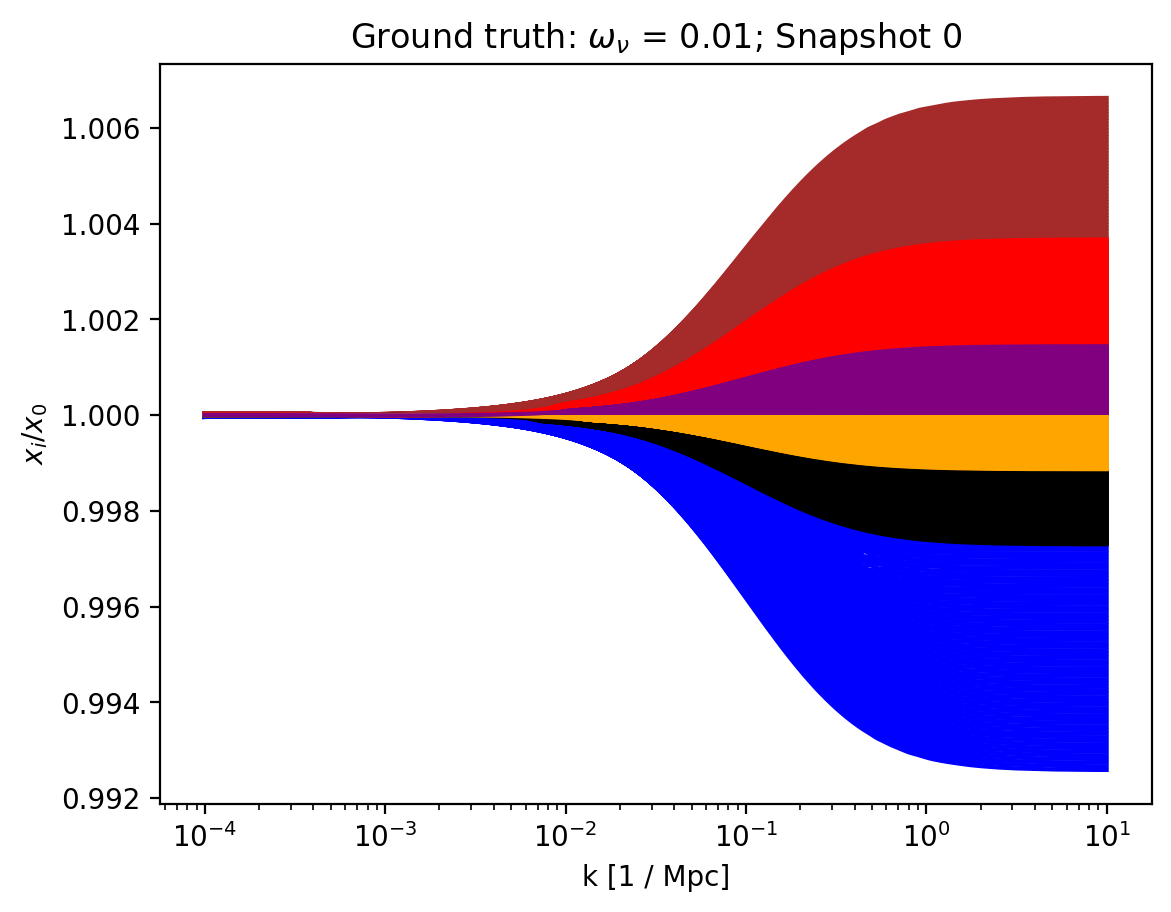

In [9]:
fig, axs = plt.subplots()
A_s = [spectra.cosm.loc[i]["A_s"] for i in range(7)]
from numpy.polynomial.polynomial import polyfit

chi_space = []
max_err_space = []
best_b = []
best_m = []

for i in range(len(spec_sims)):    
    data = spec_sims[onh2_strs[i]]
    onh2 = onh2s[i]
    dTitle = "Space " + str(i) + "th"
    ks, rats = spectra.model_ratios_true(snap_index, data, axs, massive='x',
        skips=[7, 8], omnuh2_str=onh2_strs[i], suppress_legend=True);
    true_asymptotes = np.array([rats[i][len(rats[i]) - 1] for i in range(len(rats))])
               
    x6 = onh2 * np.log(A_s[1:] / A_s[0])
    b6, m6 = polyfit(x6, true_asymptotes, 1)
    pred6 = m6 * x6 + b6
    best_b.append(b6)
    best_m.append(m6)
    
    errors = (true_asymptotes - pred6) / true_asymptotes * 100
    max_err_space.append(max(errors))           
               
    chisq6 = (true_asymptotes - pred6) ** 2 / pred6
    red_chisq6 = sum(chisq6) / len(x6)
    chi_space.append(red_chisq6)

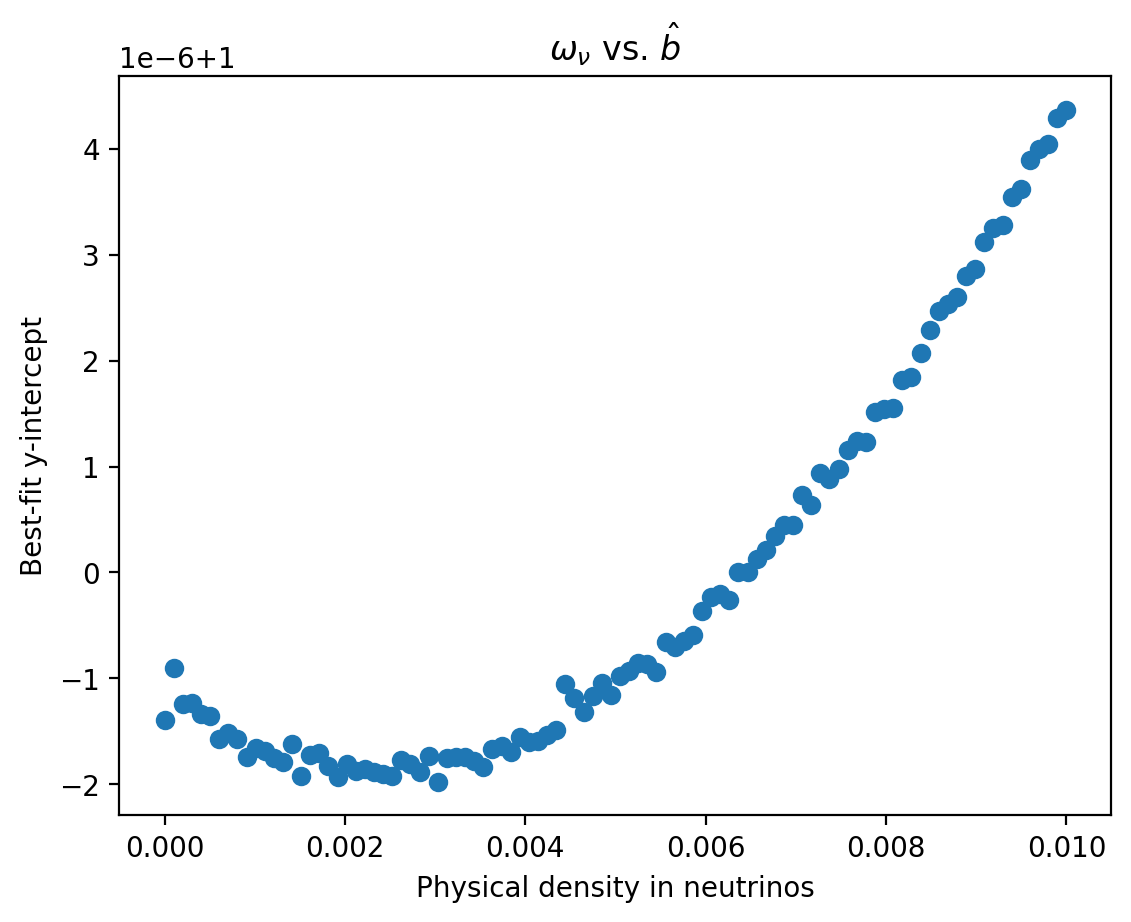

In [14]:
plt.title(r"$\omega_\nu$ vs. $\hat{b}$")
plt.ylabel("Best-fit y-intercept")
plt.xlabel("Physical density in neutrinos")
plt.scatter(onh2s, best_b)
plt.savefig("yintercept.png")

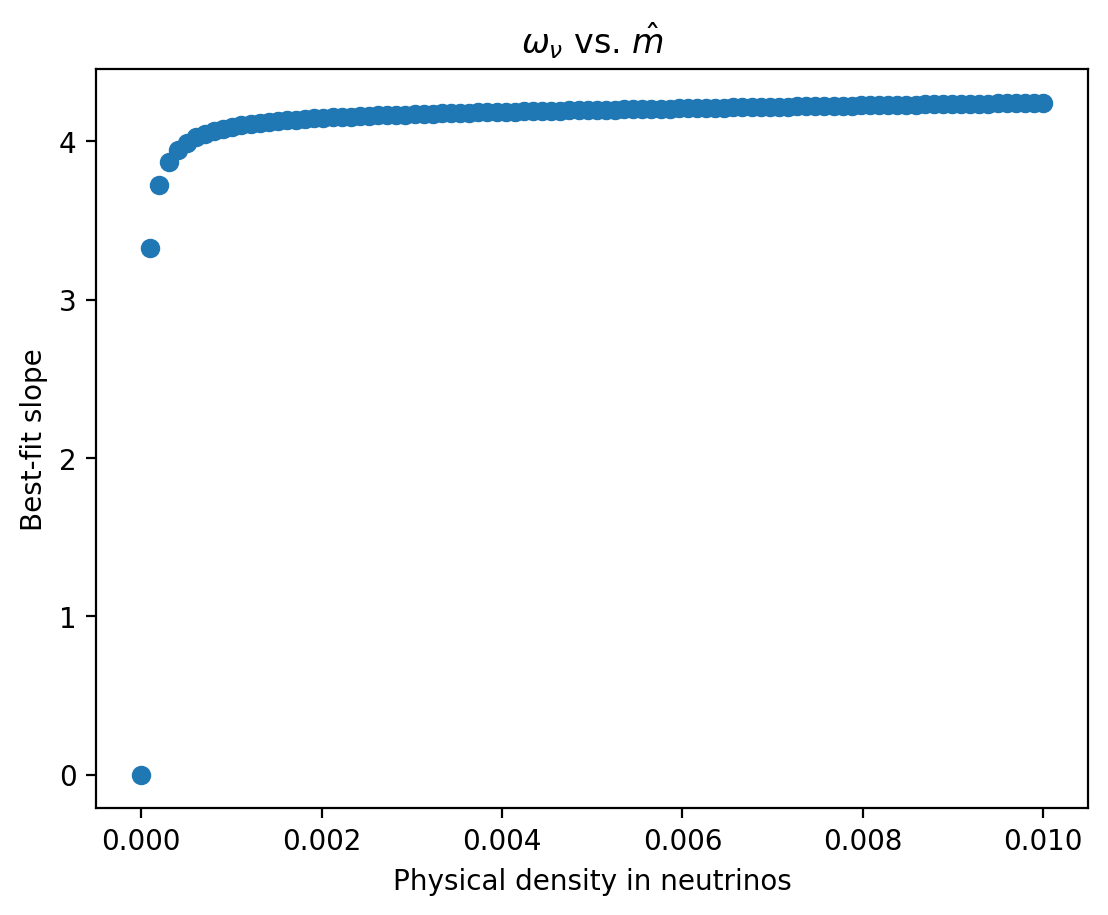

In [15]:
plt.title(r"$\omega_\nu$ vs. $\hat{m}$")
plt.ylabel("Best-fit slope")
plt.xlabel("Physical density in neutrinos")
plt.scatter(onh2s, best_m)
plt.savefig("slope.png")

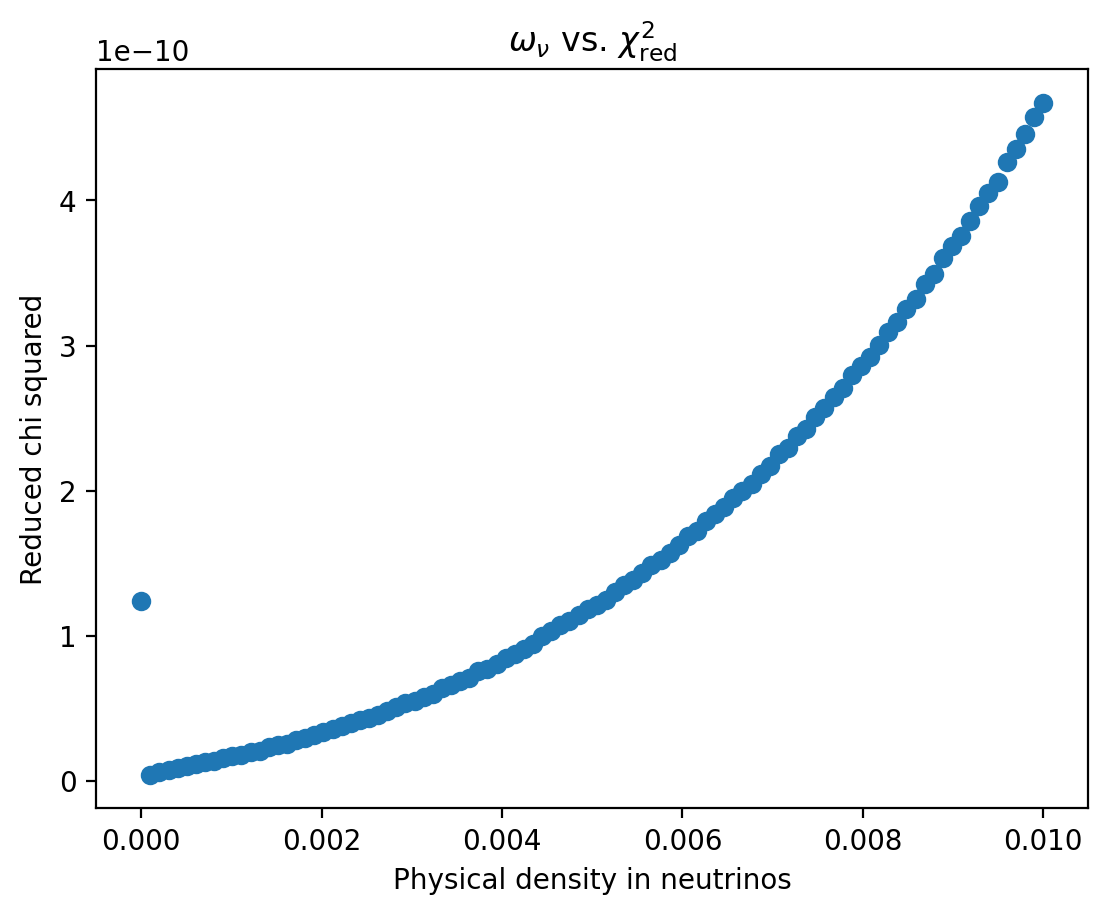

In [16]:
plt.title(r"$\omega_\nu$ vs. $\chi_\mathrm{red}^2$")
plt.ylabel("Reduced chi squared")
plt.xlabel("Physical density in neutrinos")
plt.scatter(onh2s, chi_space)
plt.savefig("redchi2.png")

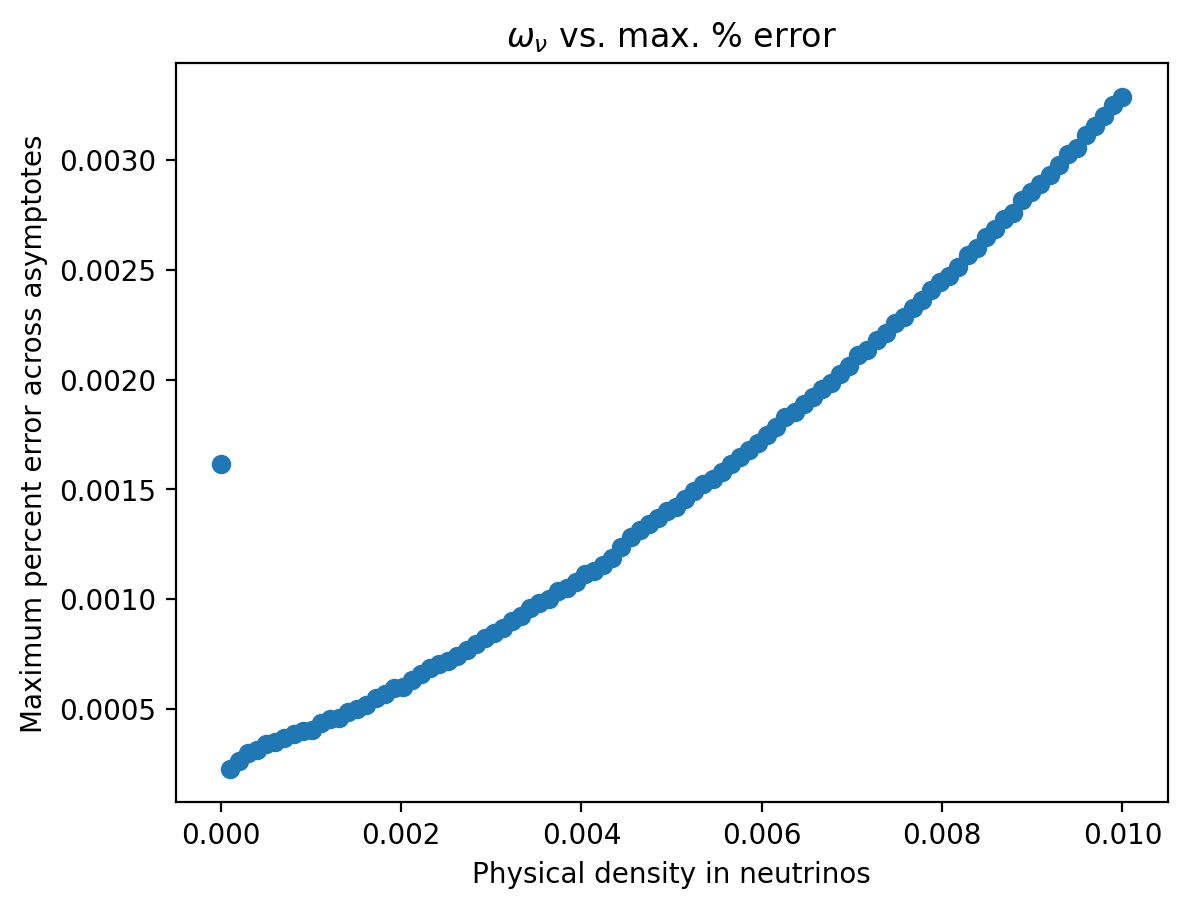

In [17]:
plt.title(r"$\omega_\nu$ vs. max. % error")
plt.ylabel("Maximum percent error across asymptotes")
plt.xlabel("Physical density in neutrinos")
plt.scatter(onh2s, max_err_space)
plt.savefig("percent_error.png")